In [4]:
import numpy as np
import matplotlib.pyplot as plt
from networkx.classes import neighbors
from skimage import io
from skimage.color import rgb2gray
from skimage.color.colorconv import ydbdr_from_rgb
import cv2
from torch.nn.functional import threshold

In [2]:
x, y = 1,1
seed_input = (x,y)

In [16]:
# Load the image
image = cv2.imread('segment_images/800wm.jpeg')

In [6]:
# Convert the image to LUV color space
# convert rgb to float 
image = image.astype(np.float32) / 255.0

# check image in each color channel is normalized 0,1
assert np.all(image[:, :, 0] >= 0) and np.all(image[:, :, 0] <= 1)
assert np.all(image[:, :, 1] >= 0) and np.all(image[:, :, 1] <= 1)
assert np.all(image[:, :, 2] >= 0) and np.all(image[:, :, 2] <= 1)
# check image shape
assert image.shape[2] == 3
# check image dtype
assert image.dtype == np.float32

In [8]:
def rgb_to_luv_vectorized(image):
    # Normalize RGB to [0,1]
    rgb = image.astype(float) / 255.0
    
    # Apply gamma correction
    mask = rgb <= 0.04045
    rgb[mask] /= 12.92
    rgb[~mask] = ((rgb[~mask] + 0.055) / 1.055) ** 2.4
    
    # RGB to XYZ matrix
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    X = r * 0.412453 + g * 0.357580 + b * 0.180423
    Y = r * 0.212671 + g * 0.715160 + b * 0.072169
    Z = r * 0.019334 + g * 0.119193 + b * 0.950227
    
    # Constants for white point D65
    Yn = 1.0
    xn, yn = 0.312713, 0.329016
    un = 4 * xn / (xn + 15 * yn + 3 * (1 - xn - yn))
    vn = 9 * yn / (xn + 15 * yn + 3 * (1 - xn - yn))
    
    # Avoid division by zero
    epsilon = 1e-10
    denominator = X + 15 * Y + 3 * Z
    denominator = np.maximum(denominator, epsilon)
    
    # Calculate u' and v'
    u = 4 * X / denominator
    v = 9 * Y / denominator
    
    # Calculate L*
    Y_ratio = Y / Yn
    mask = Y_ratio > 0.008856
    L = np.zeros_like(Y_ratio)
    L[mask] = 116 * (Y_ratio[mask] ** (1/3)) - 16
    L[~mask] = 903.3 * Y_ratio[~mask]
    
    # Calculate u* and v*
    U = 13 * L * (u - un)
    V = 13 * L * (v - vn)
    
    # Stack channels
    luv_image = np.stack([L, U, V], axis=2)
    return luv_image

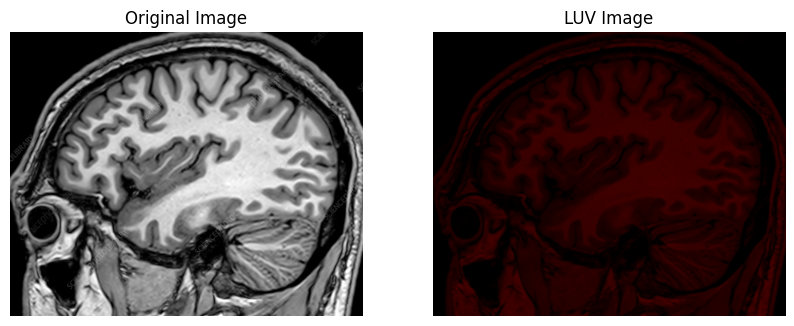

In [12]:
# Convert the image to LUV color space and see the difference
image_luv = rgb_to_luv_vectorized(image)

# plot the image and the LUV image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_luv)
plt.title('LUV Image')
plt.axis('off')
plt.show()

In [13]:
image_luv.shape

(646, 800, 3)

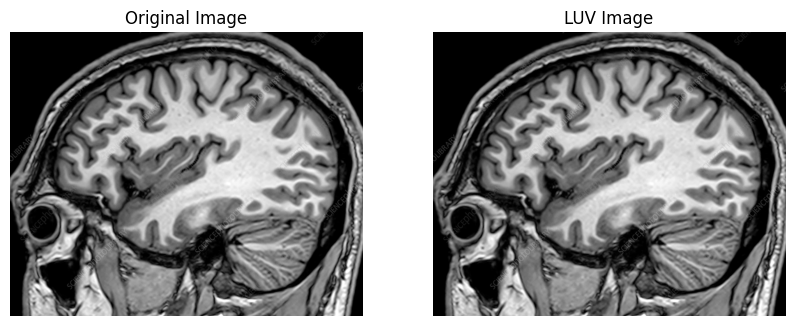

In [14]:
image_luv_gray = rgb2gray(image_luv)
image_gray = rgb2gray(image)

# plot the image and the LUV image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_luv_gray, cmap='gray')
plt.title('LUV Image')
plt.axis('off')
plt.show()

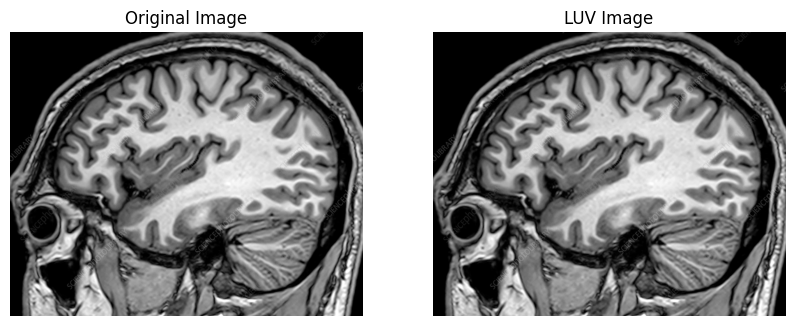

In [18]:
if len(image.shape) == 3:
    # Convert to grayscale for simplicity
    gray_image = np.mean(image, axis=2).astype(np.float32)
else:
    gray_image = image.copy()

# get the seed location
height, width = image_gray.shape

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.title('LUV Image')
plt.axis('off')
plt.show()

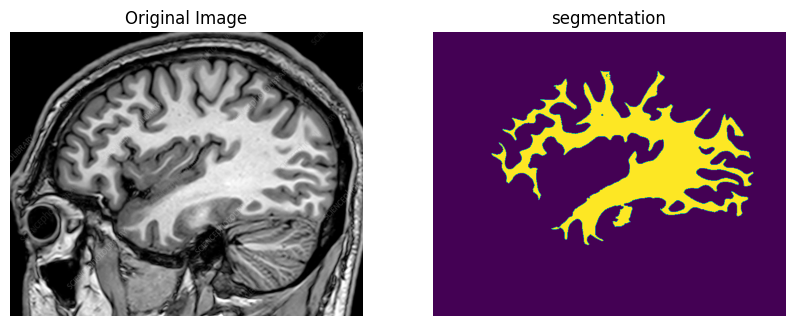

In [22]:
neighbors = [
    (-1, -1), (-1, 0), (-1, 1),
    (0, -1),         (0, 1),
    (1, -1), (1, 0), (1, 1)
]

seeds = [[480, 335]]
threshold = 50

if len(image.shape) == 3:
    # Convert to grayscale for simplicity
    gray_image = np.mean(image, axis=2).astype(np.uint8)
else:
    gray_image = image.copy()

height, width = gray_image.shape
# create segmentation to draw over the image for all seeds
overall_segmentation = np.zeros((height, width), dtype=np.uint8)
# initialize segment for each seed
seed_segment = np.zeros((height, width), dtype=np.uint8)

# Process each seed point separately (start enumerate from 1 to multiply by)
for seed_idx, (seed_x, seed_y) in enumerate(seeds, 1):
    # Skip if out of bounds
    if 0 <= seed_x < width and 0 <= seed_y < height:
        # to address if it is visited or not
        visited = np.zeros((height, width), dtype=bool)
        # reset segment for each seed
        seed_segment = np.zeros((height, width), dtype=np.uint8)

        # Get seed pixel value
        seed_value = gray_image[seed_y, seed_x]

        # Initialize queue with seed ( the only (x,y) and the rest are (y,x)
        processing_queue = [(seed_x, seed_y)]
        visited[seed_y, seed_x] = True
        seed_segment[seed_y, seed_x] = 1

        # # Define 4-connected neighbors
        # neighbors = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        # test 8 neighbors
        neighbors = [
            (-1, -1), (-1, 0), (-1, 1),
            (0, -1),         (0, 1),
            (1, -1), (1, 0), (1, 1)
        ]

        # Process queue
        while processing_queue:
            x, y = processing_queue.pop(0)

            for dx, dy in neighbors:
                nx, ny = x + dx, y + dy

                # Check bounds
                if 0 <= nx < width and 0 <= ny < height:
                    # Skip if already visited
                    if not visited[ny, nx]:
                        visited[ny, nx] = True
                        # Check if pixel is within threshold
                        pixel_value = gray_image[ny, nx]
                        if abs(int(pixel_value) - int(seed_value)) <= threshold:
                            seed_segment[ny, nx] = 1
                            processing_queue.append((nx, ny))

    # Add this segment to the final segmentation
    overall_segmentation = np.maximum(overall_segmentation, seed_segment * seed_idx)

# Plot the original image and the segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(overall_segmentation)
plt.title('segmentation')
plt.axis('off')
plt.show()


# region growing using luv color space

In [23]:
def region_growing(image, seeds, threshold=50, use_luv=True):
    """
    Perform region growing segmentation with optional CIELUV color space support

    Args:
        image: NumPy array of image data (RGB or grayscale)
        seeds: List of (x, y) tuples as starting points
        threshold: Distance threshold for region inclusion
        use_luv: Boolean to use CIELUV color space (default: True)

    Returns:
        NumPy array of binary segmentation mask
    """
    # Handle color space conversion
    if len(image.shape) == 3 and use_luv:
        # Convert BGR to CIELUV for better perceptual color distance
        # Note: OpenCV expects BGR order by default
        luv_image = rgb_to_luv_vectorized(image)
        processed_image = luv_image
    elif len(image.shape) == 3 and not use_luv:
        # Keep original RGB image
        processed_image = image.copy()
    else:
        # For grayscale images
        processed_image = image.copy()
        use_luv = False  # Force use_luv to False for grayscale

    # Get dimensions based on original image
    if len(image.shape) == 3:
        height, width, _ = processed_image.shape
    else:
        height, width = processed_image.shape
    
    # Create segmentation mask for all seeds
    overall_segmentation = np.zeros((height, width), dtype=np.uint8)
    
    # Process each seed point separately
    for seed_idx, (seed_x, seed_y) in enumerate(seeds, 1):
        # Skip if out of bounds
        if 0 <= seed_x < width and 0 <= seed_y < height:
            visited = np.zeros((height, width), dtype=bool)
            seed_segment = np.zeros((height, width), dtype=np.uint8)

            # Get seed pixel value
            if len(processed_image.shape) == 3:
                seed_value = processed_image[seed_y, seed_x, :].astype(np.float32)
            else:
                seed_value = processed_image[seed_y, seed_x]

            # Initialize queue with seed
            processing_queue = [(seed_x, seed_y)]
            visited[seed_y, seed_x] = True
            seed_segment[seed_y, seed_x] = 1

            # Define 8-connected neighbors
            neighbors = [
                (-1, -1), (-1, 0), (-1, 1),
                (0, -1),         (0, 1),
                (1, -1), (1, 0), (1, 1)
            ]

            # Process queue
            while processing_queue:
                x, y = processing_queue.pop(0)

                for dx, dy in neighbors:
                    nx, ny = x + dx, y + dy

                    # Check bounds
                    if 0 <= nx < width and 0 <= ny < height:
                        # Skip if already visited
                        if not visited[ny, nx]:
                            visited[ny, nx] = True
                            
                            # Calculate color difference based on color space
                            if len(processed_image.shape) == 3:
                                pixel_value = processed_image[ny, nx, :].astype(np.float32)
                                if use_luv:
                                    # For CIELUV, use Euclidean distance in LUV space
                                    color_diff = np.sqrt(np.sum((pixel_value - seed_value) ** 2))
                                else:
                                    # For RGB, use Euclidean distance
                                    color_diff = np.sqrt(np.sum((pixel_value - seed_value) ** 2))
                            else:
                                # For grayscale
                                pixel_value = processed_image[ny, nx]
                                color_diff = abs(float(pixel_value) - float(seed_value))
                            
                            # Check if pixel is within threshold
                            if color_diff <= threshold:
                                seed_segment[ny, nx] = 1
                                processing_queue.append((nx, ny))

        # Add this segment to the final segmentation
        overall_segmentation = np.maximum(overall_segmentation, seed_segment * seed_idx)

    return overall_segmentation

In [47]:
# test image 
image = cv2.imread('segment_images/2 color.jpg')
seeds = [(359, 170)]
segmented_luv = region_growing(image, seeds, threshold=50, use_luv=True)

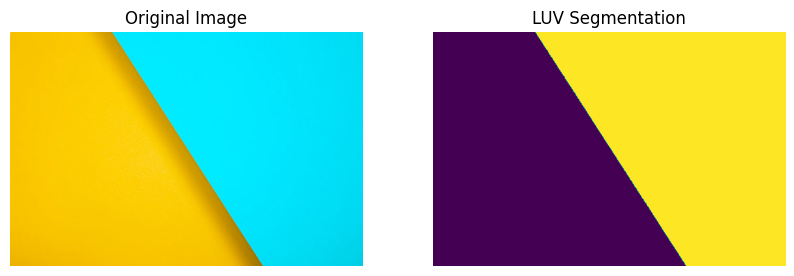

In [48]:
# Plot the original image and the segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_luv)
plt.title('LUV Segmentation')
plt.axis('off')
plt.show()

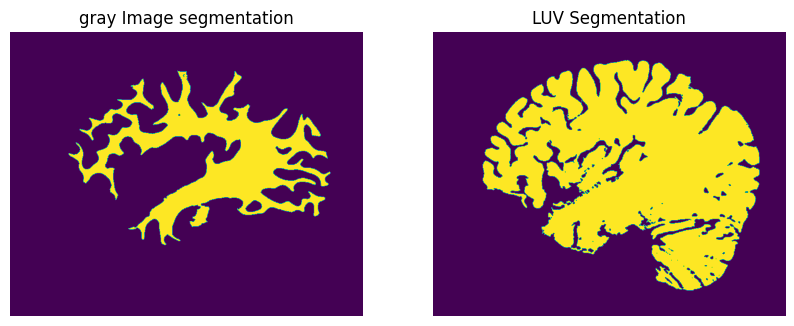

In [26]:
# Plot the original image and the segmentation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(overall_segmentation)
plt.title('gray Image segmentation')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(segmented_luv)
plt.title('LUV Segmentation')
plt.axis('off')
plt.show()

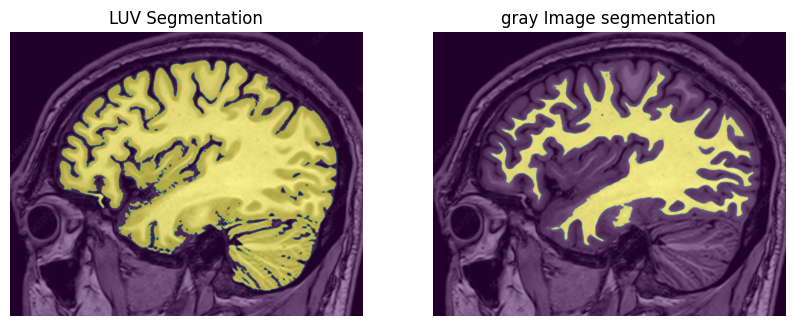

In [27]:
# plot the segmentation on top of the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.imshow(segmented_luv, alpha=0.5)
plt.title('LUV Segmentation')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.imshow(overall_segmentation, alpha=0.5)
plt.title('gray Image segmentation')
plt.axis('off')
plt.show()

In [9]:
from PyQt5.QtGui import QPixmap, QImage
import cv2
import numpy as np
def qimage_to_cv2(qimage):
    qformat = qimage.format()

    if qformat == QImage.Format_Grayscale8:
        width = qimage.width()
        height = qimage.height()
        ptr = qimage.bits()
        ptr.setsize(height * width)
        arr = np.frombuffer(ptr, dtype=np.uint8).reshape((height, width))
        return arr
    else:
        qimage = qimage.convertToFormat(QImage.Format_RGB888)
        width = qimage.width()
        height = qimage.height()
        ptr = qimage.bits()
        ptr.setsize(height * width * 3)
        arr = np.frombuffer(ptr, dtype=np.uint8).reshape((height, width, 3))
        arr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        return arr

def region_growing(image, seeds, threshold=50, use_luv=True):
    """
    Perform region growing segmentation with optional CIELUV color space support

    Args:
        image: NumPy array of image data (RGB or grayscale)
        seeds: List of (x, y) tuples as starting points
        threshold: Distance threshold for region inclusion
        use_luv: Boolean to use CIELUV color space (default: True)

    Returns:
        NumPy array of binary segmentation mask
    """
    # convert qimage to cv2 image
    if isinstance(image, QImage):
        image = qimage_to_cv2(image)

    # Handle color space conversion
    if len(image.shape) == 3 and use_luv:
        # Convert BGR to CIELUV for better perceptual color distance
        # Note: OpenCV expects BGR order by default
        luv_image = rgb_to_luv_vectorized(image)
        processed_image = luv_image
    elif len(image.shape) == 3 and not use_luv:
        # Keep original RGB image
        processed_image = image.copy()
    else:
        # For grayscale images
        processed_image = image.copy()
        use_luv = False  # Force use_luv to False for grayscale

    # Get dimensions based on original image
    if len(image.shape) == 3:
        height, width, _ = processed_image.shape
    else:
        height, width = processed_image.shape

    # Create segmentation mask for all seeds
    overall_segmentation = np.zeros((height, width), dtype=np.uint8)

    # Process each seed point separately
    for seed_idx, (seed_x, seed_y) in enumerate(seeds, 1):
        # Skip if out of bounds
        if 0 <= seed_x < width and 0 <= seed_y < height:
            visited = np.zeros((height, width), dtype=bool)
            seed_segment = np.zeros((height, width), dtype=np.uint8)

            # Get seed pixel value
            if len(processed_image.shape) == 3:
                seed_value = processed_image[seed_y, seed_x, :].astype(np.float32)
            else:
                seed_value = processed_image[seed_y, seed_x]

            # Initialize queue with seed
            processing_queue = [(seed_x, seed_y)]
            visited[seed_y, seed_x] = True
            seed_segment[seed_y, seed_x] = 1

            # Define 8-connected neighbors
            neighbors = [
                (-1, -1), (-1, 0), (-1, 1),
                (0, -1), (0, 1),
                (1, -1), (1, 0), (1, 1)
            ]

            # Process queue
            while processing_queue:
                x, y = processing_queue.pop(0)

                for dx, dy in neighbors:
                    nx, ny = x + dx, y + dy

                    # Check bounds
                    if 0 <= nx < width and 0 <= ny < height:
                        # Skip if already visited
                        if not visited[ny, nx]:
                            visited[ny, nx] = True

                            # Calculate color difference based on color space
                            if len(processed_image.shape) == 3:
                                pixel_value = processed_image[ny, nx, :].astype(np.float32)
                                if use_luv:
                                    # For CIELUV, use Euclidean distance in LUV space
                                    color_diff = np.sqrt(np.sum((pixel_value - seed_value) ** 2))
                                else:
                                    # For RGB, use Euclidean distance
                                    color_diff = np.sqrt(np.sum((pixel_value - seed_value) ** 2))
                            else:
                                # For grayscale
                                pixel_value = processed_image[ny, nx]
                                color_diff = abs(float(pixel_value) - float(seed_value))

                            # Check if pixel is within threshold
                            if color_diff <= threshold:
                                seed_segment[ny, nx] = 1
                                processing_queue.append((nx, ny))

        # Add this segment to the final segmentation
        overall_segmentation = np.maximum(overall_segmentation, seed_segment * seed_idx)

    return overall_segmentation


In [10]:
image = cv2.imread("segment_images/2 color.jpg")
seeds = [[145, 145]]
# convert image to qimage
qimage = QImage(image.data, image.shape[0], image.shape[1],3 * image.shape[0], QImage.Format_RGB888)
normal_segment = region_growing(image, seeds, threshold=50, use_luv=False)
luv_segment = region_growing(image, seeds, threshold=50, use_luv=True)

In [14]:
print(image)

[[[255 207  93]
  [233 196   4]
  [245 193   2]
  ...
  [  0 220 244]
  [  0 219 243]
  [  0 219 243]]

 [[255 205  90]
  [234 196   2]
  [245 193   2]
  ...
  [  0 219 243]
  [  0 219 243]
  [  0 219 243]]

 [[255 203  82]
  [233 195   0]
  [246 194   4]
  ...
  [  0 219 243]
  [  0 219 243]
  [  0 219 243]]

 ...

 [[235 176   0]
  [236 177   1]
  [236 177   1]
  ...
  [  1 205 228]
  [  1 205 228]
  [  1 205 228]]

 [[235 176   0]
  [235 176   0]
  [235 176   0]
  ...
  [  1 206 227]
  [  1 206 227]
  [  1 206 227]]

 [[235 176   0]
  [235 176   0]
  [235 176   0]
  ...
  [  1 206 227]
  [  1 206 227]
  [  0 205 226]]]


In [15]:
print(normal_segment.shape)

(360, 541)


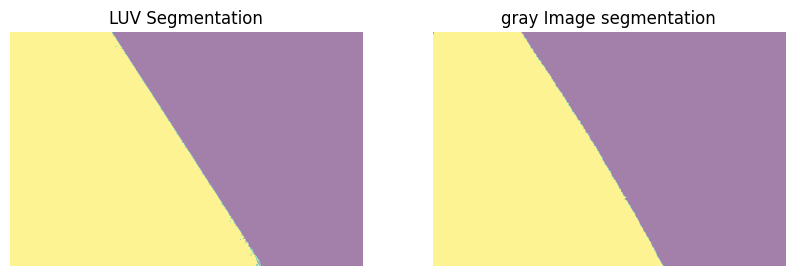

In [12]:
import matplotlib.pyplot as plt
# plot the segmentation on top of the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
# plt.imshow(image)
plt.imshow(luv_segment, alpha=0.5)
plt.title('LUV Segmentation')
plt.axis('off')
plt.subplot(1, 2, 2)
# plt.imshow(image)
plt.imshow(normal_segment, alpha=0.5)
plt.title('gray Image segmentation')
plt.axis('off')
plt.show()

In [34]:
luvv_image = rgb_to_luv_vectorized(image)

In [44]:
image = cv2.imread("segment_images/800wm.jpeg")
seeds = [(145, 145)]
normal_segment = region_growing(image, seeds, threshold=50, use_luv=False)

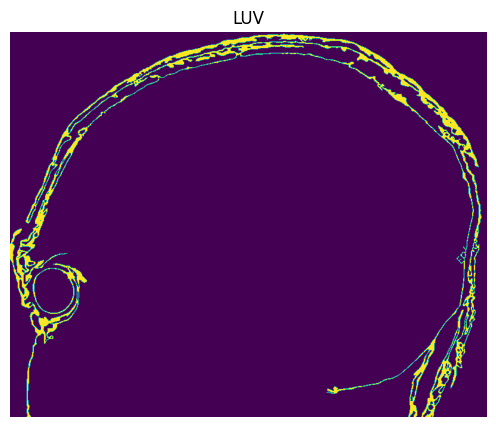

In [45]:
# plot the segmentation on top of the original image
plt.figure(figsize=(10, 5))
plt.imshow(normal_segment)
plt.title('LUV')
plt.axis('off')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-40.97116951404388..117.90677297947681].


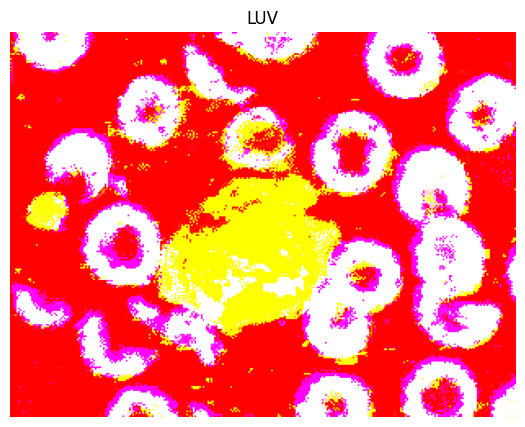

In [35]:
# plot the segmentation on top of the original image
plt.figure(figsize=(10, 5))
plt.imshow(luvv_image)
plt.title('LUV')
plt.axis('off')

plt.show()